#### Importing Python Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    style="whitegrid",
    context="talk",
    palette="deep"
)
import warnings
warnings.filterwarnings("ignore")

C:\Users\samsa\Documents\Projects\Stock-Market-Prediction\venv\Lib\site-packages\lightning_fabric\__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


#### Data Utilities

In [2]:
def download_prices(
    ticker: str,
    start_date: str = "2016-01-01",
    end_date: str = "2026-01-01",
    auto_adjust: bool = True,
) -> pd.DataFrame:
    df = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        auto_adjust=auto_adjust,
        progress=False
    )

    # Handle MultiIndex columns (rare but possible)
    if isinstance(df.columns, pd.MultiIndex):
        try:
            df.columns = df.columns.droplevel("Ticker")
        except Exception:
            df.columns = df.columns.get_level_values(0)

    df = df.reset_index()

    if "Close" not in df.columns:
        raise ValueError(f"'Close' column not found for {ticker}. Columns: {df.columns.tolist()}")

    return df[["Date", "Close"]].copy()

In [3]:
def to_neuralprophet_df(df_prices: pd.DataFrame) -> pd.DataFrame:
    df = df_prices.rename(columns={"Date": "ds", "Close": "y"}).copy()
    df["ds"] = pd.to_datetime(df["ds"])
    return df[["ds", "y"]].dropna()

#### Modelling Utilities

In [4]:
def fit_neuralprophet(
    df_np: pd.DataFrame,
    yearly_seasonality: bool = True,
    weekly_seasonality: bool = True,
    daily_seasonality: bool = True,
    epochs: int = 50,
) -> NeuralProphet:
    m = NeuralProphet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality,
        epochs=epochs
    )
    m.fit(df_np)
    return m

In [5]:
def make_forecast(
    model: NeuralProphet,
    df_np: pd.DataFrame,
    periods: int = 365,
) -> pd.DataFrame:
    future = model.make_future_dataframe(
        df_np,
        periods=periods,
        n_historic_predictions=True
    )
    forecast = model.predict(future)
    return forecast

#### Feature Summaries (Month / Weekday)

In [6]:
def monthly_summary(forecast: pd.DataFrame) -> pd.DataFrame:
    out = forecast.copy()
    out["month"] = pd.to_datetime(out["ds"]).dt.month
    return out.groupby("month", as_index=False)["yhat1"].mean()

In [7]:
def weekday_summary(
    forecast: pd.DataFrame,
    weekly_order=None,
) -> pd.DataFrame:
    if weekly_order is None:
        weekly_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    out = forecast.copy()
    out["weekday"] = pd.to_datetime(out["ds"]).dt.day_name()
    grouped = out.groupby("weekday", as_index=False)["yhat1"].mean()

    grouped["weekday"] = pd.Categorical(grouped["weekday"], categories=weekly_order, ordered=True)
    grouped = grouped.sort_values("weekday").reset_index(drop=True)
    return grouped

#### Plotting the Graphs

In [8]:
def plot_actual_vs_forecast(df_np: pd.DataFrame, forecast: pd.DataFrame, ticker: str, figsize=(14, 6)):
    plt.figure(figsize=figsize)

    sns.lineplot(data=df_np, x="ds", y="y", label="Actual", linewidth=2)
    sns.lineplot(data=forecast, x="ds", y="yhat1", label="Forecast", linewidth=2)

    # Confidence interval if present
    if {"yhat1_lower", "yhat1_upper"}.issubset(forecast.columns):
        plt.fill_between(
            forecast["ds"],
            forecast["yhat1_lower"],
            forecast["yhat1_upper"],
            alpha=0.25,
            label="Confidence Interval"
        )

    plt.title(f"{ticker} – Actual vs Forecast Price")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
def plot_component_series(forecast: pd.DataFrame, component: str, ticker: str, title: str = None, figsize=(14, 5)):
    if component not in forecast.columns:
        raise ValueError(f"Component '{component}' not found in forecast columns.")

    plt.figure(figsize=figsize)
    sns.lineplot(data=forecast, x="ds", y=component, linewidth=2)
    plt.title(title or f"{ticker} – {component} Component")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

In [10]:
def plot_monthly_component(monthly_df: pd.DataFrame, ticker: str, figsize=(12, 5)):
    plt.figure(figsize=figsize)
    sns.lineplot(data=monthly_df, x="month", y="yhat1", marker="o", linewidth=2)
    plt.title(f"{ticker} – Monthly Component (Avg Forecasted Price)")
    plt.xlabel("Month")
    plt.ylabel("Average Forecasted Price")
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()

In [11]:
def plot_weekly_component(weekday_df: pd.DataFrame, ticker: str, figsize=(12, 5)):
    plt.figure(figsize=figsize)
    sns.barplot(data=weekday_df, x="weekday", y="yhat1", estimator=np.mean)
    plt.title(f"{ticker} – Weekly Component (Avg Forecasted Price)")
    plt.xlabel("Day of Week")
    plt.ylabel("Average Forecasted Price")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

#### Pipeline for Ticker

In [12]:
def run_ticker_pipeline(
    ticker: str,
    start_date: str = "2016-01-01",
    end_date: str = "2026-01-01",
    forecast_days: int = 365,
    weekly_order=None,
    plot: bool = True,
    epochs: int = 50,
):
    if weekly_order is None:
        weekly_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    prices = download_prices(ticker, start_date, end_date, auto_adjust=True)
    df_np = to_neuralprophet_df(prices)

    model = fit_neuralprophet(
        df_np,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        epochs=epochs
    )
    forecast = make_forecast(model, df_np, periods=forecast_days)

    m_summary = monthly_summary(forecast)
    w_summary = weekday_summary(forecast, weekly_order=weekly_order)

    if plot:
        plot_actual_vs_forecast(df_np, forecast, ticker)
        plot_component_series(forecast, "trend", ticker, title=f"{ticker} - Trend Component")

        # yearly column name can vary; pick first one containing "yearly"
        yearly_cols = [c for c in forecast.columns if "yearly" in c]
        if yearly_cols:
            plot_component_series(forecast, yearly_cols[0], ticker, title=f"{ticker} - Yearly Seasonality")

        plot_monthly_component(m_summary, ticker)
        plot_weekly_component(w_summary, ticker)

    return {
        "ticker": ticker,
        "prices": prices,
        "df_np": df_np,
        "model": model,
        "forecast": forecast,
        "monthly": m_summary,
        "weekly": w_summary,
    }

#### Multi-Ticker Comparison Plots

In [13]:
def plot_yearly_seasonality_comparison(results: dict, figsize=(16, 10)):
    tickers = list(results.keys())
    fig, axes = plt.subplots(len(tickers), 1, figsize=figsize, sharex=True)

    if len(tickers) == 1:
        axes = [axes]

    for ax, t in zip(axes, tickers):
        fc = results[t]["forecast"]
        yearly_cols = [c for c in fc.columns if "yearly" in c]
        if yearly_cols:
            ax.plot(fc["ds"], fc[yearly_cols[0]], linewidth=2)
            ax.set_title(f"{t} - Yearly Seasonality")
            ax.set_ylabel("Seasonality Effect")
        else:
            ax.set_title(f"{t} - Yearly Seasonality (not found)")

    axes[-1].set_xlabel("Date")
    plt.suptitle("Yearly Seasonality Comparison", fontsize=15)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_monthly_component_comparison(results: dict, figsize=(14, 10)):
    tickers = list(results.keys())
    fig, axes = plt.subplots(len(tickers), 1, figsize=figsize, sharex=True)

    if len(tickers) == 1:
        axes = [axes]

    for ax, t in zip(axes, tickers):
        mdf = results[t]["monthly"]
        ax.plot(mdf["month"], mdf["yhat1"], marker="o", linewidth=2)
        ax.set_title(f"{t} - Monthly Component")
        ax.set_ylabel("Avg Forecasted Price")
        ax.set_xticks(range(1, 13))
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Month")
    plt.suptitle("Monthly Component Comparison", fontsize=15)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_weekly_component_comparison(results: dict, weekly_order=None, figsize=(18, 5)):
    if weekly_order is None:
        weekly_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    tickers = list(results.keys())
    fig, axes = plt.subplots(1, len(tickers), figsize=figsize, sharey=True)

    if len(tickers) == 1:
        axes = [axes]

    for ax, t in zip(axes, tickers):
        wdf = results[t]["weekly"].copy()
        wdf["weekday"] = pd.Categorical(wdf["weekday"], categories=weekly_order, ordered=True)
        wdf = wdf.sort_values("weekday")

        ax.bar(wdf["weekday"].astype(str), wdf["yhat1"])
        ax.set_title(t)
        ax.set_xlabel("Day of Week")
        ax.tick_params(axis="x", rotation=30)

    axes[0].set_ylabel("Average Forecasted Price")
    plt.suptitle("Weekly Component Comparison", fontsize=15)
    plt.tight_layout()
    plt.show()

#### Multiple Ticker Usage

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.221% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (40) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.


Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.221% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.7% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.7% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 365 rows at the end with NaNs in 'y' column.


Predicting: 40it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


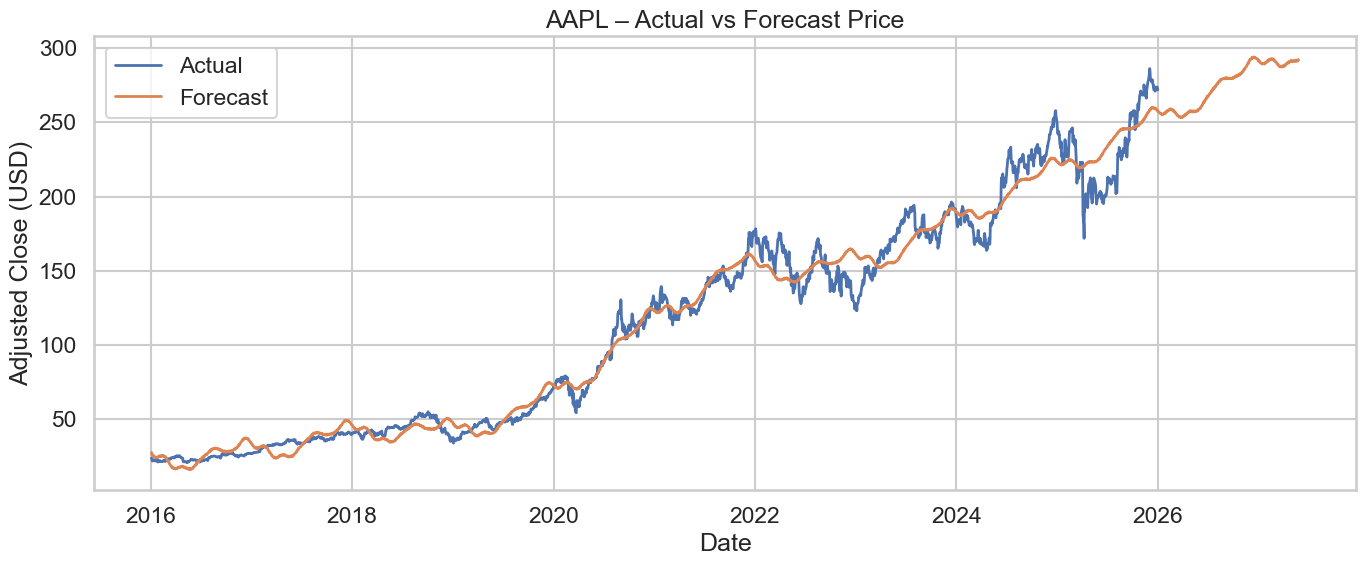

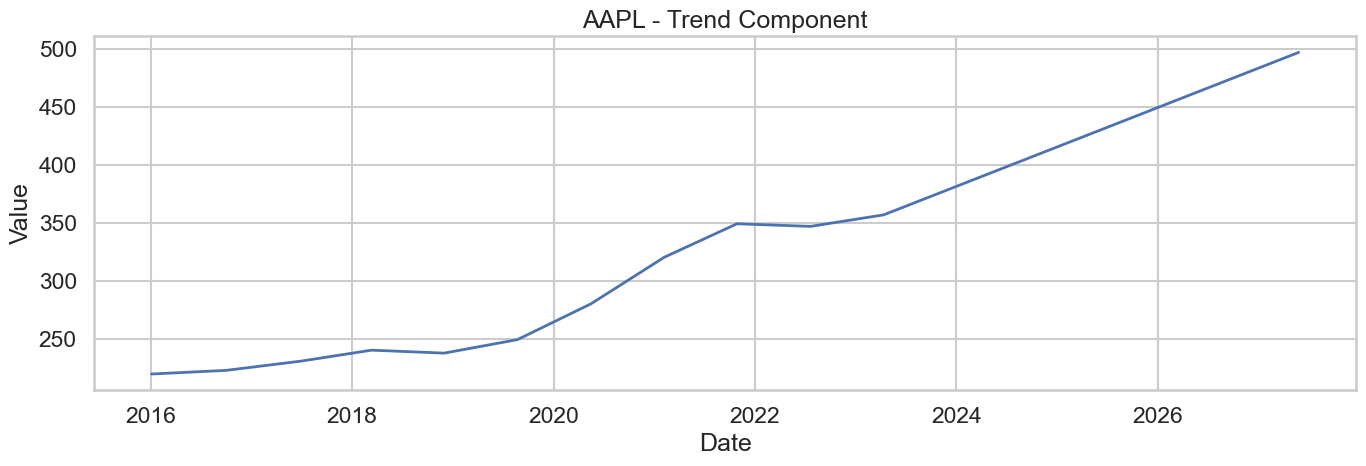

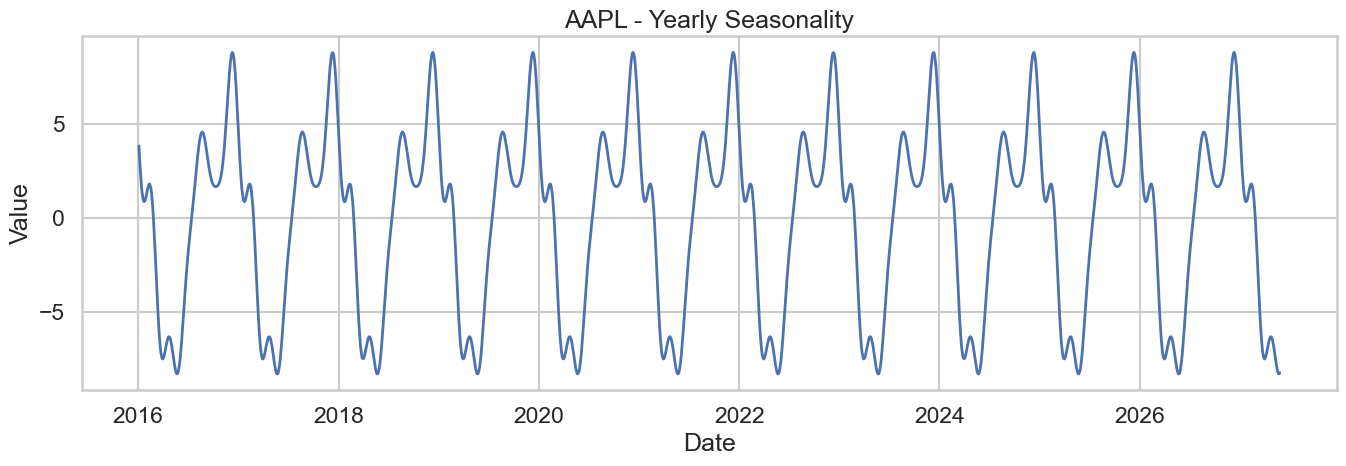

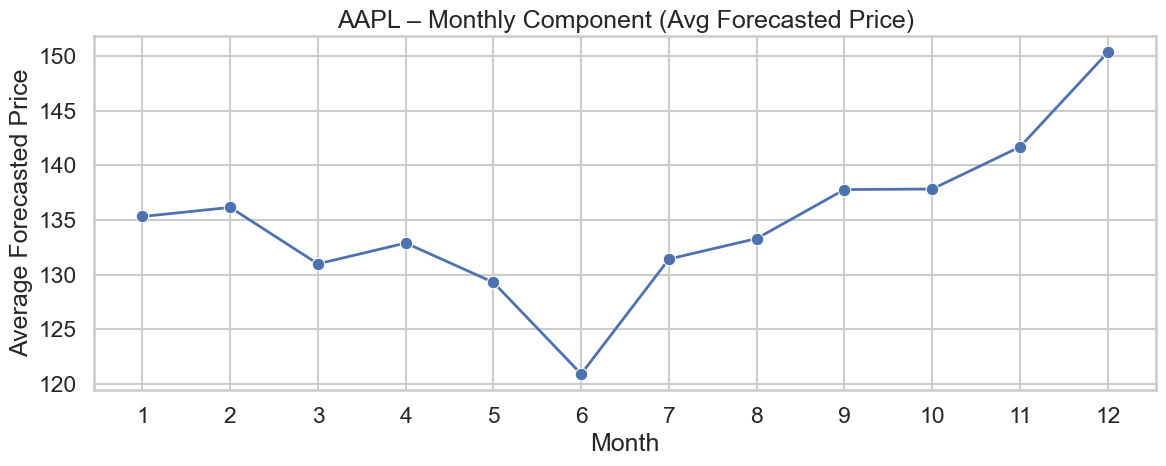

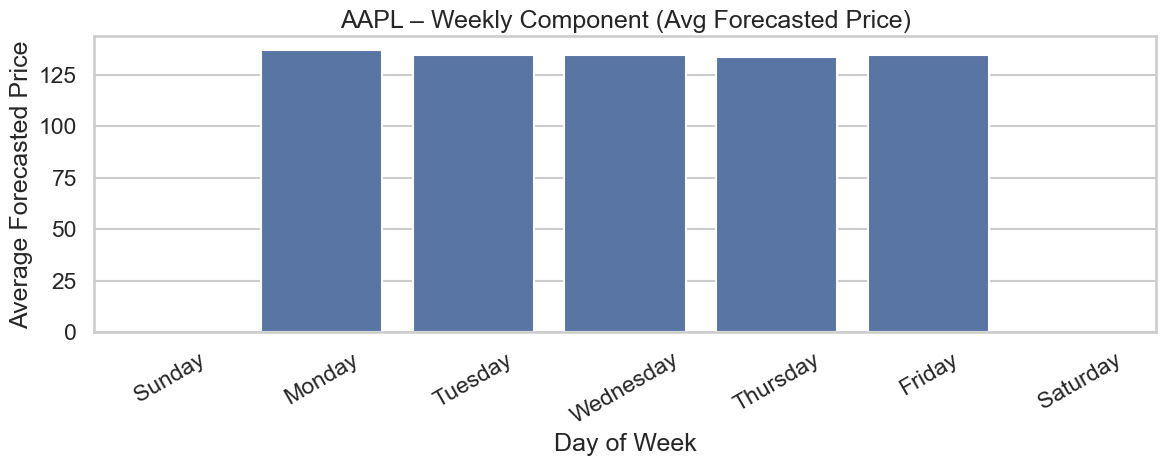

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.221% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (40) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.


Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.221% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.7% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.7% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 365 rows at the end with NaNs in 'y' column.


Predicting: 40it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


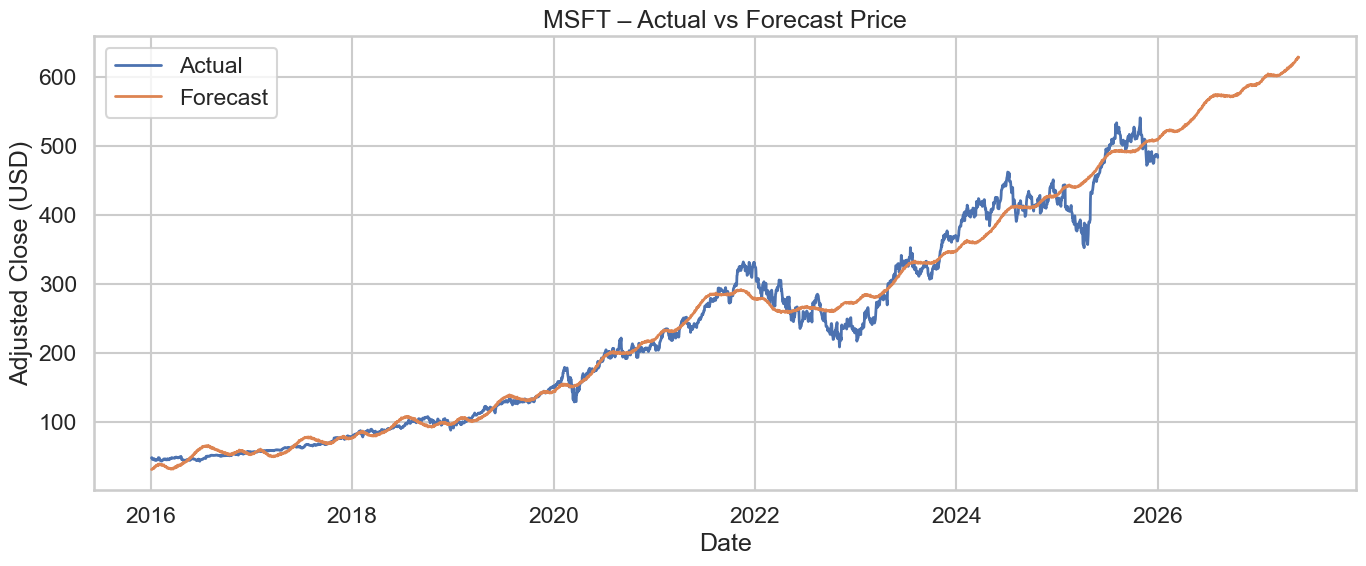

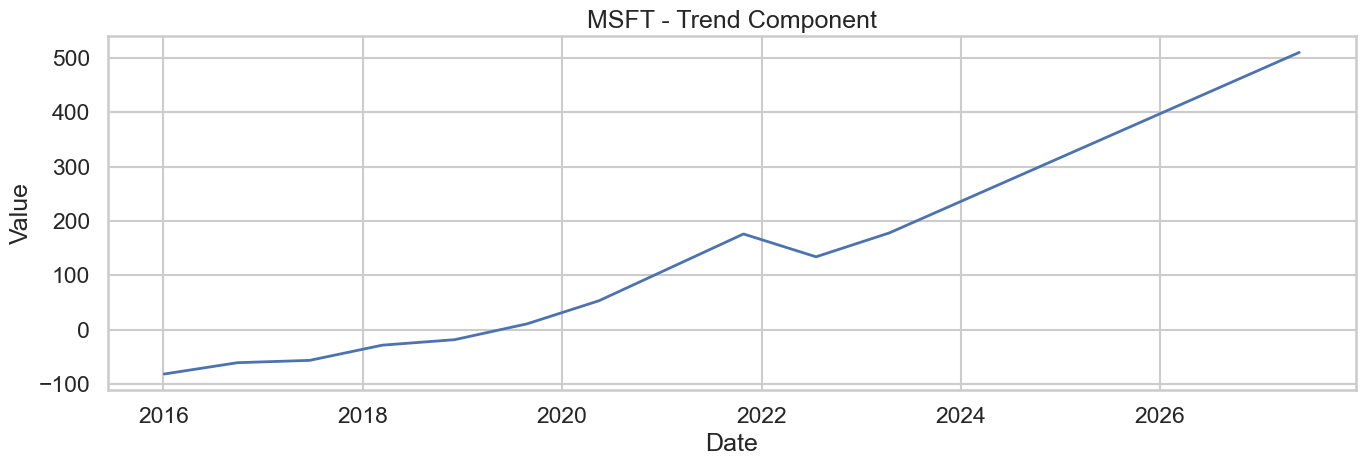

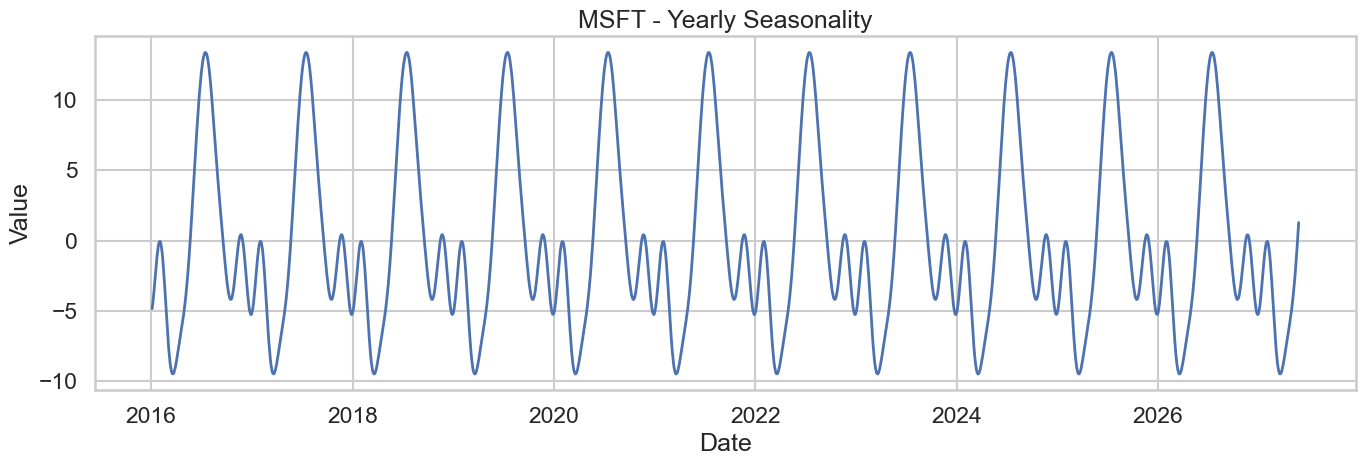

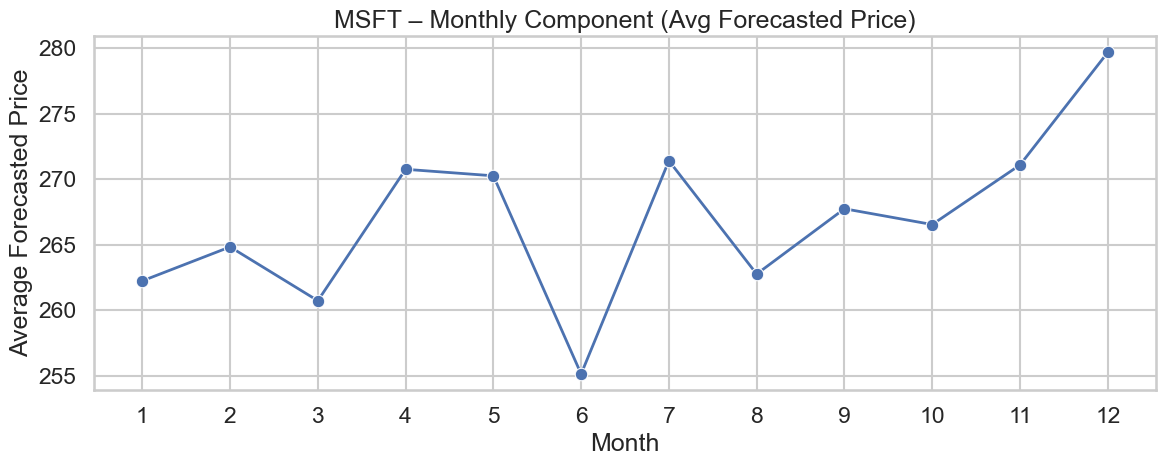

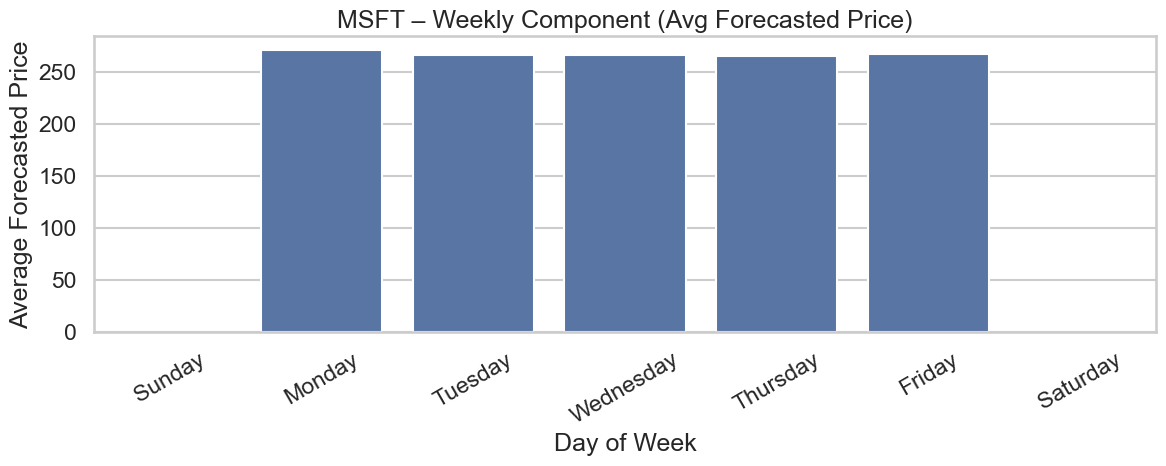

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.221% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (40) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.


Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.221% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.7% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.7% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 365 rows at the end with NaNs in 'y' column.


Predicting: 40it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


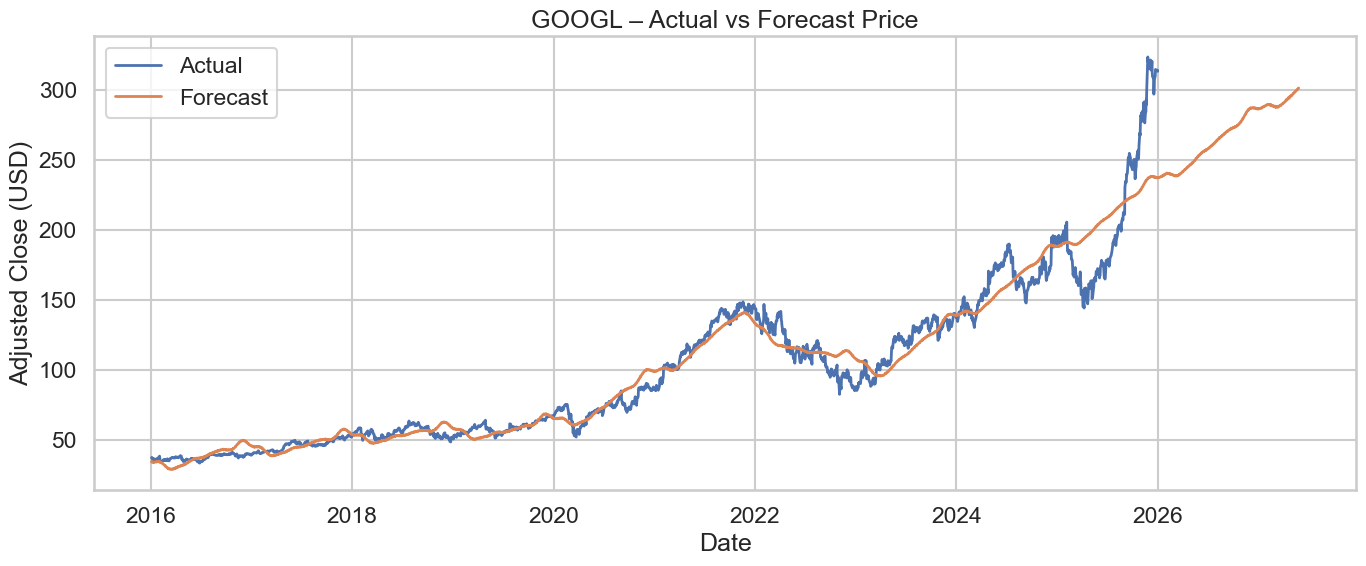

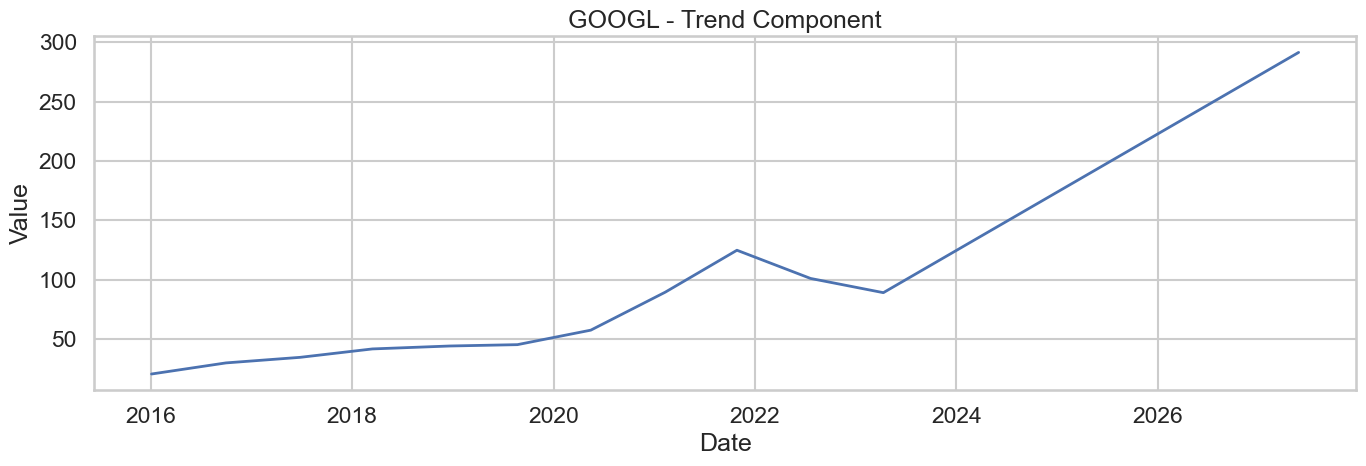

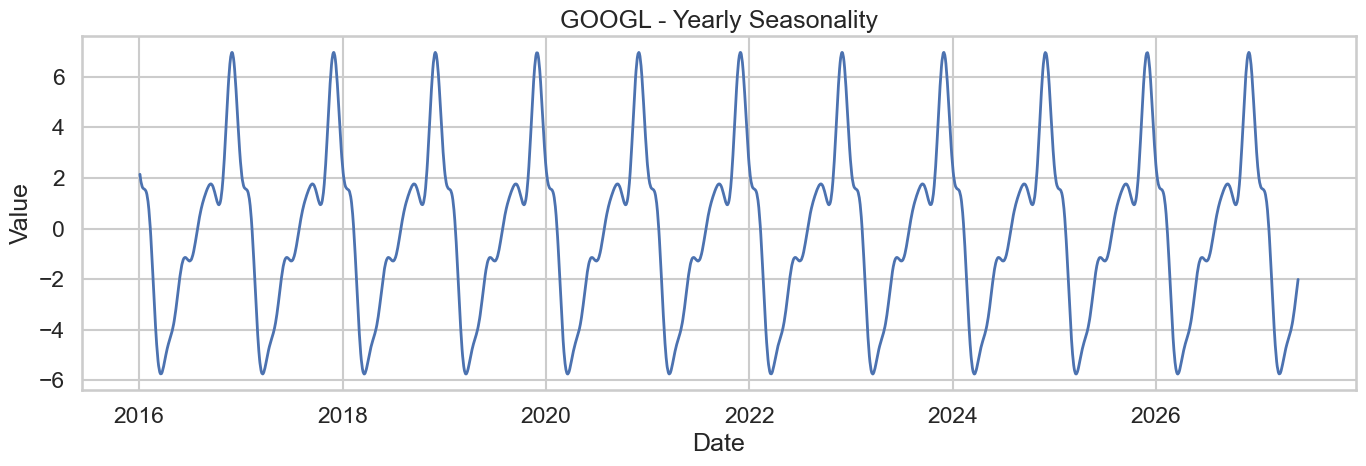

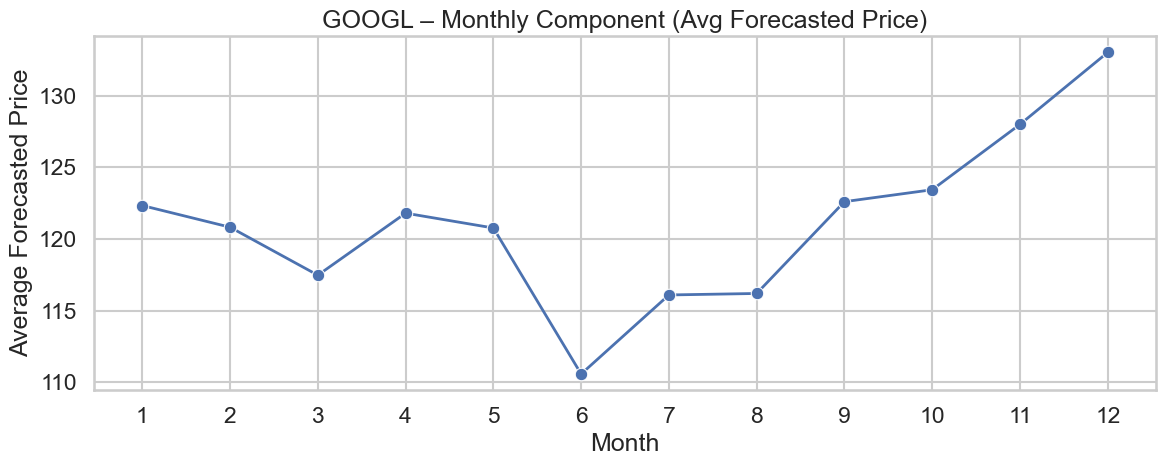

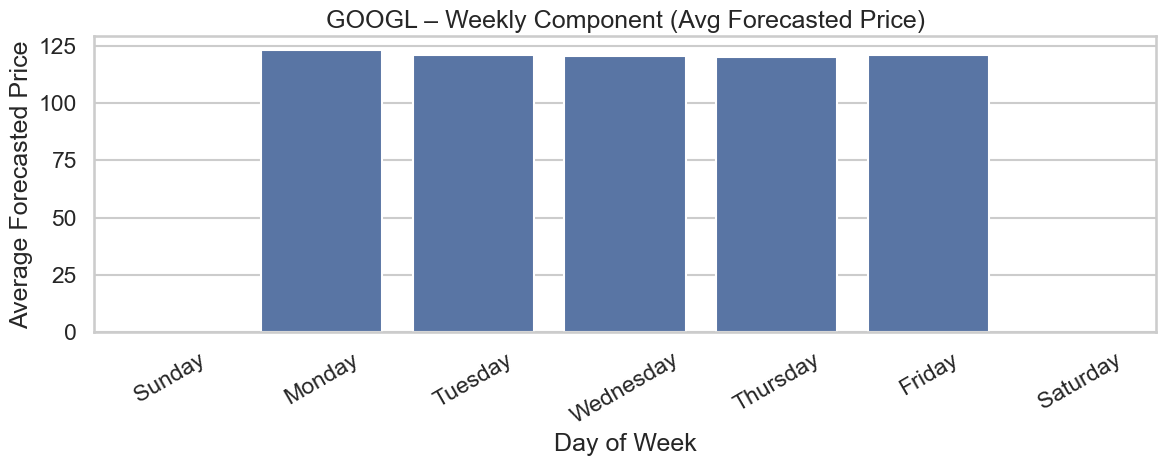

In [16]:
tickers = ["AAPL", "MSFT", "GOOGL"]

results = {
    t: run_ticker_pipeline(
        ticker=t,
        start_date="2016-01-01",
        end_date="2026-01-01",
        forecast_days=365,
        plot=True,
        epochs=50
    )
    for t in tickers
}

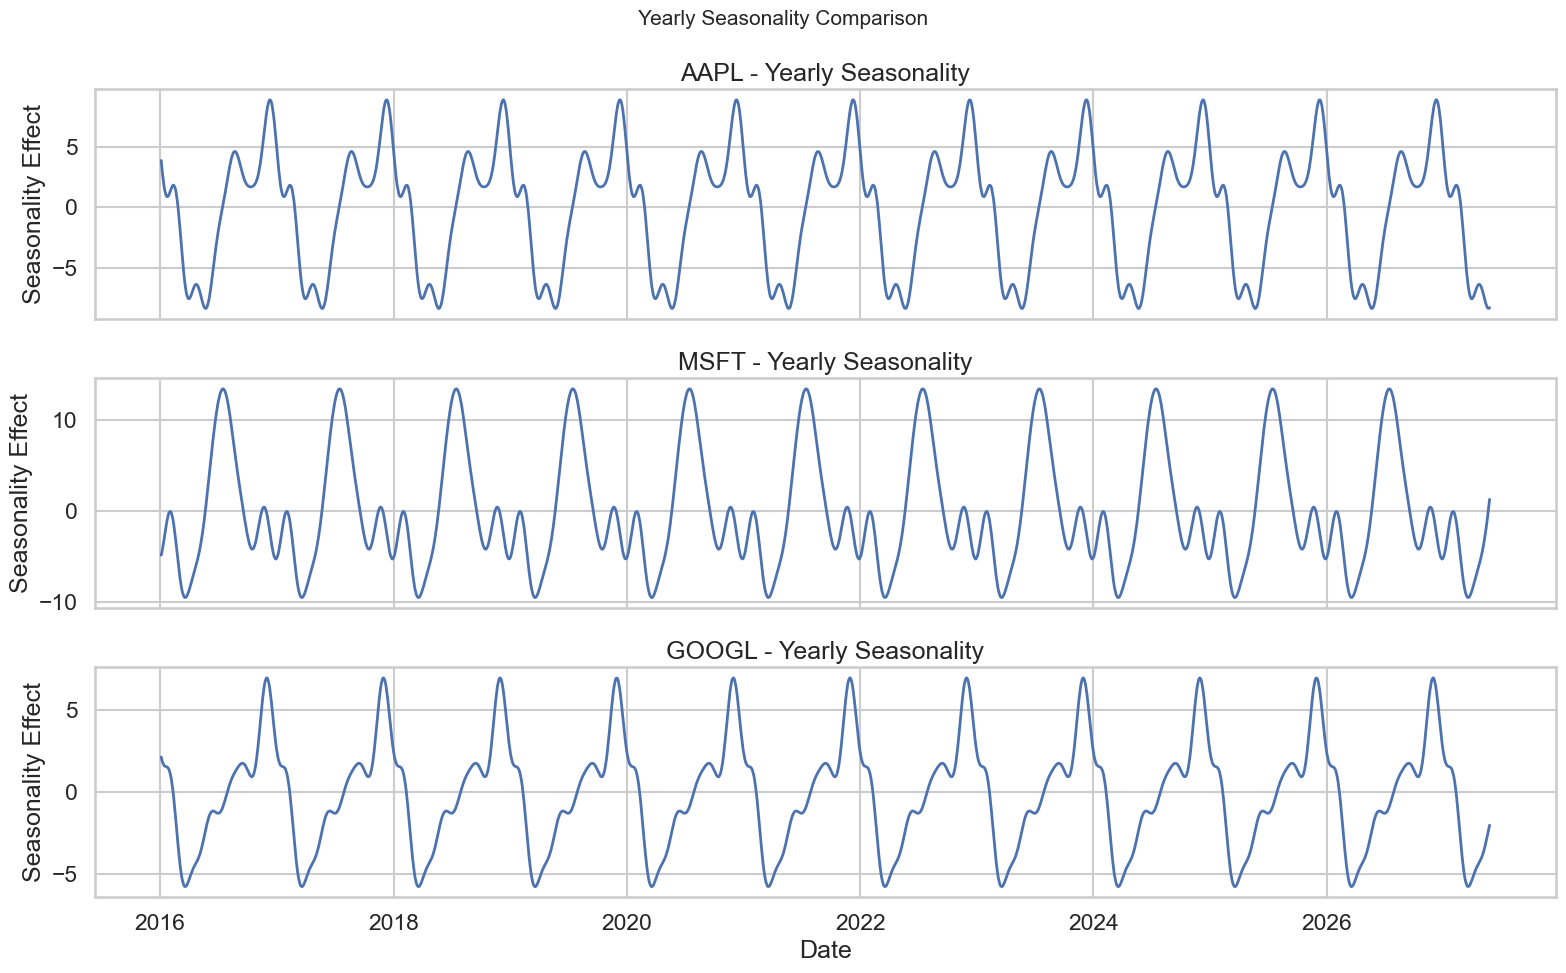

In [17]:
plot_yearly_seasonality_comparison(results)

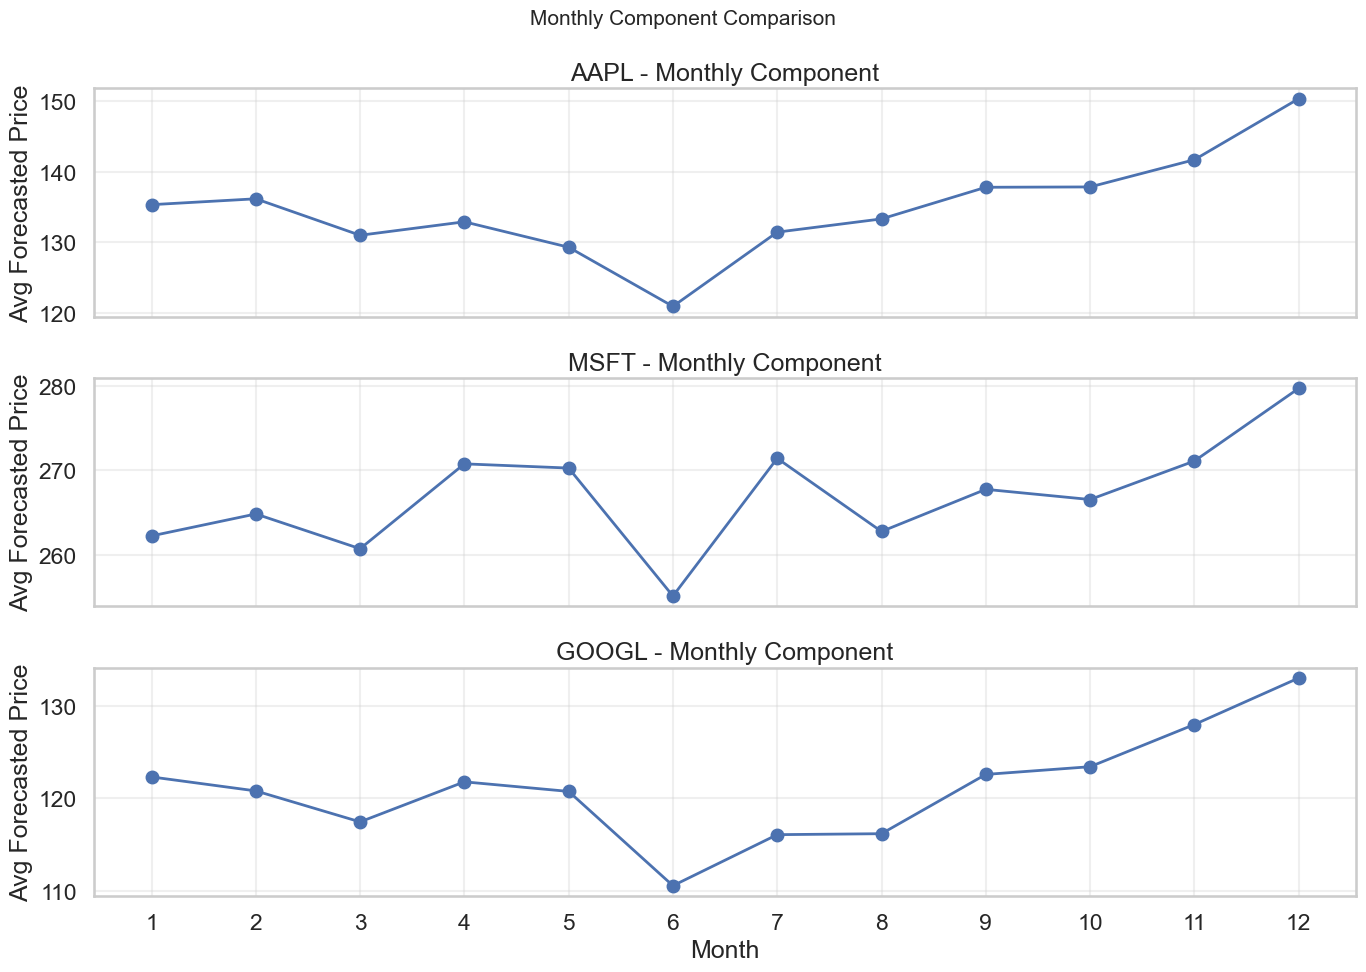

In [18]:
plot_monthly_component_comparison(results)

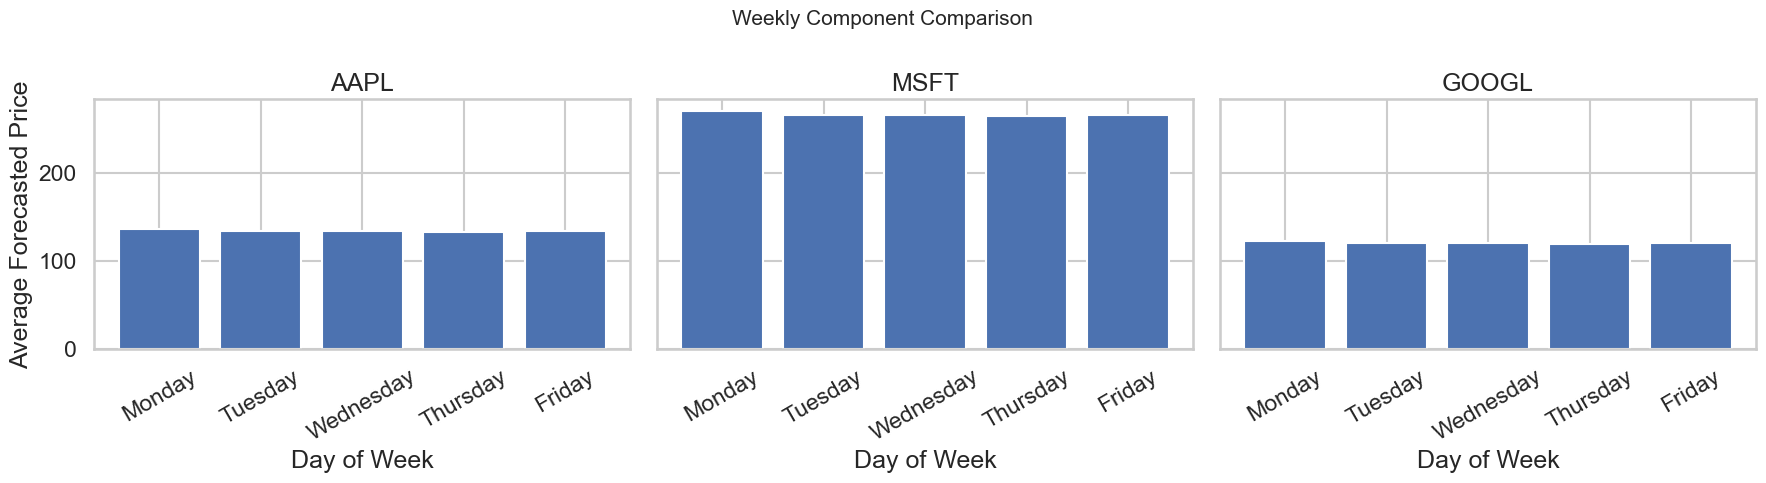

In [19]:
plot_weekly_component_comparison(results)